Метод Ньютона для нахождения нулей функции. Суть метода: берем начальное значение $x_0$, затем $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$, таким образом приближаемся к нулю функции. 

In [2]:
import torch
import math
from matplotlib import pyplot as plt


def newton_method(f, x0, eps=1e-6, max_iter=100):
    x = torch.tensor([x0], requires_grad=True)
    for i in range(max_iter):
        y = f(x)
        y.backward()
        if torch.abs(y) < eps:
            break
        x_new = x - y / x.grad
        x = x_new.detach().requires_grad_(True)
    return x.item(), i + 1

def simple_iteration_method(f, x0, eps=1e-6, max_iter=1000):
    phi = lambda x: x - 0.1 * f(x)
    for i in range(max_iter):
        x1 = phi(x0)
        if abs(f(x1)) < eps:
            break
        x0 = x1
    return x1, i + 1


Функция. для которой метод Ньютона сходится сильно быстрее метода простых итераций:

In [3]:
def f(x):
    return x ** 2 - 3

x0 = 1.7

newton_result = newton_method(f, x0)
simple_result = simple_iteration_method(f, x0)

print(f"Newton's method, x={newton_result[0]}, f(x)={f(newton_result[0])}, num steps={newton_result[1]}")
print(f"Simple iterations method, x={simple_result[0]}, f(x)={f(simple_result[0])}, num steps={simple_result[1]}")

Newton's method, x=1.7320507764816284, f(x)=-1.0768938807359518e-07, num steps=3
Simple iterations method, x=1.7320505885102004, f(x)=-7.588414683290523e-07, num steps=28


In [4]:
def newton_step_count_estimate(eps):
    return torch.log2(torch.log2(1 / eps))

def f(x):
    return torch.exp(torch.sin(x)) + x - torch.log(x) - 5 + torch.sin(x)

epsillons = torch.logspace(-20, -0.5, 1000, dtype=torch.float32)
counts_theor = newton_step_count_estimate(epsillons)


def plot_steps(f, x_0):
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.plot(torch.linspace(1, 10, 1000), f(torch.linspace(1, 10, 1000)))
    plt.show()
    
    counts_prac = torch.zeros_like(counts_theor)

    for i, eps in enumerate(epsillons.tolist()):
        counts_prac[i] = newton_method(f, x_0, eps, 100)[1]

    plt.plot(epsillons, counts_theor, label="theoretical iters number")
    plt.plot(epsillons, counts_prac, label="practical iters number")
    plt.xlabel("epsillon")
    plt.ylabel("number of iterations")
    plt.xscale('log')
    plt.legend()
    plt.show()


Проверим зависимость скорости сходимости от epsillon:

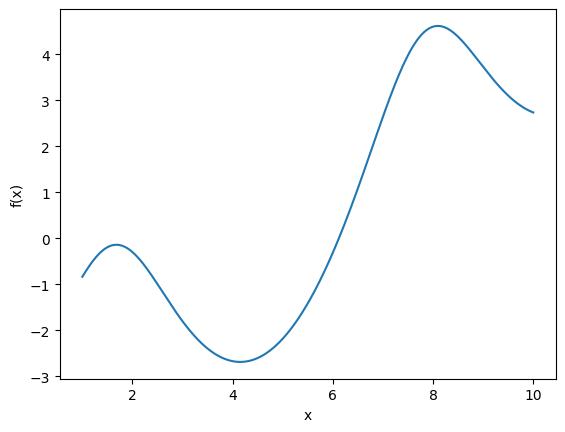

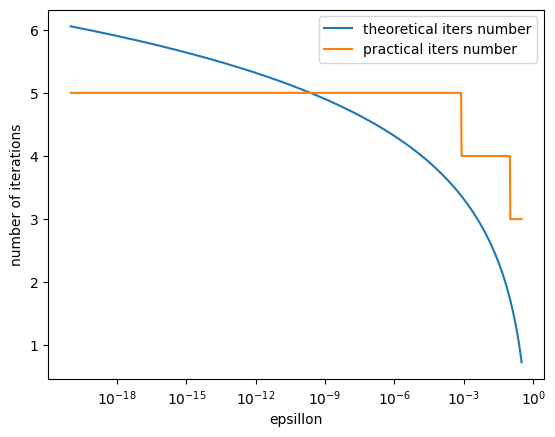

In [5]:
def f(x):
    return torch.exp(torch.sin(x)) + x - torch.log(x) - 5 + torch.sin(x)

plot_steps(f, 5.0)

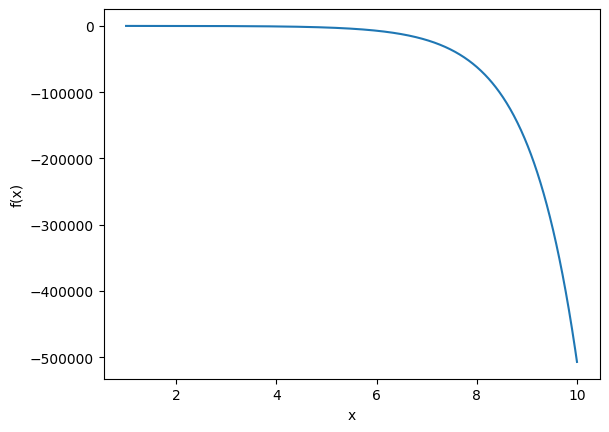

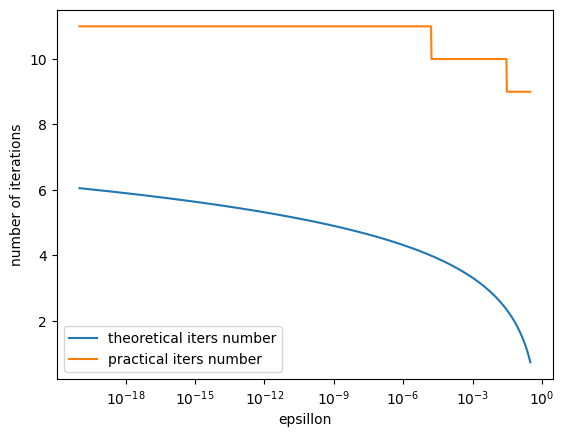

In [6]:
def f(x):
    return torch.log(x) ** 2 - 10 * torch.exp(x) * torch.log(x)

plot_steps(f, 6.0)

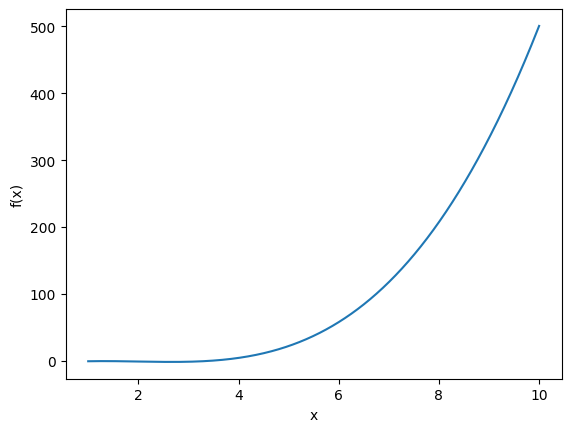

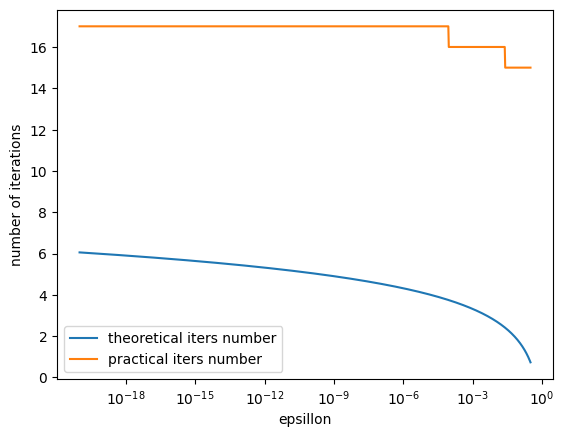

In [9]:
def f(x):
    return (x - 1) * (x - 2) * (x - 3) - torch.sqrt(x)

plot_steps(f, 200.0)

На практике скорость сходимости действительно похожа на теоретическую (с учетом О-большого)

In [8]:
def broyden_method(f, x0, eps=1e-6, max_iters=1000):
    x = x0.clone()
    B = torch.eye(x.shape[0]).double()
    y = f(x)
    for i in range(max_iters):
        s = torch.linalg.solve(B, -y)
        x_new = x + s.squeeze(-1)
        y_new = f(x_new)
        y_delta = y_new - y
        if torch.norm(y_delta) < eps:
            return x_new
        B += torch.outer((y_delta - B @ s), s) / torch.inner(s, s)

        x, y = x_new, y_new
    raise ValueError("Broyden's method did not converge")

def f(x):
    return torch.tensor([(x[0] - 1) ** 2, (x[1] - 2) ** 2])


broyden_method(f, torch.tensor([0.5, 1.]).double())




tensor([1.0015, 2.0001], dtype=torch.float64)